In [1]:
# data retrieval
import requests

# data storage and manipulation
import numpy as np
import pandas as pd

# functional tools to allow for model fine tuning
from functools import partial, update_wrapper

# modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, \
                            precision_score, \
                            recall_score, \
                            confusion_matrix

# from my modeling repo
import exploratory
import evaluation
import curves

In [2]:
%matplotlib inline

### --------------------------------------------------------------

# Census Data Analysis

### --------------------------------------------------------------

# 0. Overview

### Prerequisites

This notebook contains the results of a quick exercise in data analysis and prediction, with the goal being to develop a model to predict whether a given person, based on the provided data, makes more than \$50K per year.

Depending on which version of Jupyter Notebook you are running, you may have to increase your data transmission limits in order to be able to download the dataset within the confines of the notebook, which is what I have done here. This can be achieved through passing a new limit to the *NotebookApp.iopub_data_rate_limit* option while launching Jupyter Notebook from the command line:
    
    jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

The original dataset and description can be found at: https://archive.ics.uci.edu/ml/datasets/Adult

### Analysis Description

I put together this analysis in an effort to showcase and also test in a new context some analysis & ML evaluation modules that I have been working on. The Notebook has 3 parts:

1) Get Data
- Pull dataset from the UC Irvine website
- Check for and deal with duplicates and nulls
- Slight reworking of table
    
    
2) Exploratory Data Analaysis
- Investigate certain features, looking for relationships with income level
- The approach taken here is very visual
- Descriptive statistics are also performed
    
    
3) Modeling
- Cross-validate a Random Forest Classifier
- Tune depth parameter to reduce overfitting
- Introduce example use case and develop appropriate cost function

# 1. Get Data

### Retrieve

In [3]:
def get_census_data():
    cols = ['age', 'workclass', 'fnlwgt', 'education', 
            'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain',
            'capital_loss', 'hours_per_week', 'native_country', 
            'over_fifty_k']
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    r = requests.get(url, stream=True)
    results = [l.decode().split(',') for l in r.iter_lines()]
    r.close()
    return pd.DataFrame(results, columns=cols)

In [4]:
table = get_census_data()

In [5]:
table.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
len(table)

32562

### Check for problems

#### Duplicates

In [7]:
len(table[table.duplicated()])

24

In [8]:
table = table.drop_duplicates()

#### Nulls

In [9]:
table.isnull().sum()

age               0
workclass         1
fnlwgt            1
education         1
education_num     1
marital_status    1
occupation        1
relationship      1
race              1
sex               1
capital_gain      1
capital_loss      1
hours_per_week    1
native_country    1
over_fifty_k      1
dtype: int64

In [10]:
table[table.isnull()].dropna(how='all')

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k


In [11]:
table[table.workclass.isnull()]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
32561,,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [12]:
table[~table.index.isin((32561,))].isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
over_fifty_k      0
dtype: int64

In [13]:
table = table[~table.index.isin((32561,))]

### Set up response column

In [14]:
table.head(1)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


In [15]:
table.over_fifty_k.value_counts()

 <=50K    24698
 >50K      7839
Name: over_fifty_k, dtype: int64

In [16]:
table.over_fifty_k.unique()

array([' <=50K', ' >50K'], dtype=object)

In [17]:
table.over_fifty_k = table.over_fifty_k.map(lambda _:
                                           1 if _ == ' >50K'
                                           else 0)

# 2. Exploratory Data Analysis

In [18]:
table.over_fifty_k.value_counts() / len(table)

0    0.759074
1    0.240926
Name: over_fifty_k, dtype: float64

#### Notes

The classes are somewhat imbalanced, appearing here at a ratio of 3: 1 negative: postitive.

### Age

In [19]:
table.age.nunique()

73

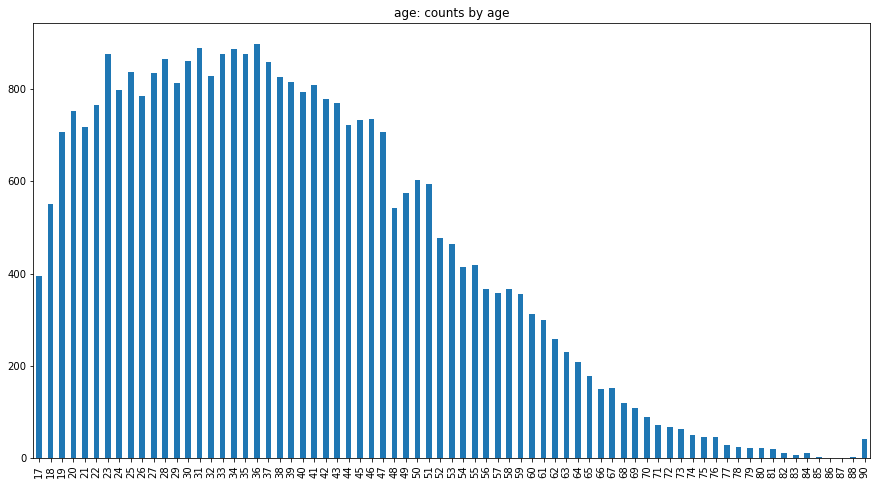

In [20]:
ax = table.age.value_counts().sort_index().plot.bar(figsize=(15, 8))
ax.title.set_text('age: counts by age')

#### Notes
    
The age data looks at first glance to be close to Normal, though positively skewed and somewhat lacking in the tails.

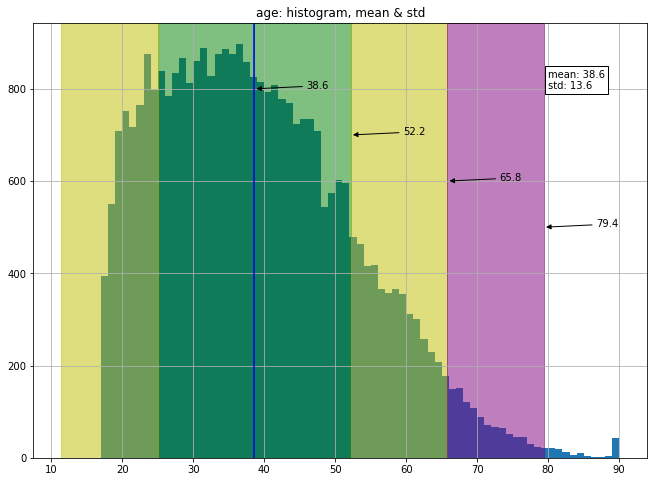

In [21]:
exploratory.center_scale_plot(table.age.astype(int), np.mean, np.std, bins=73)

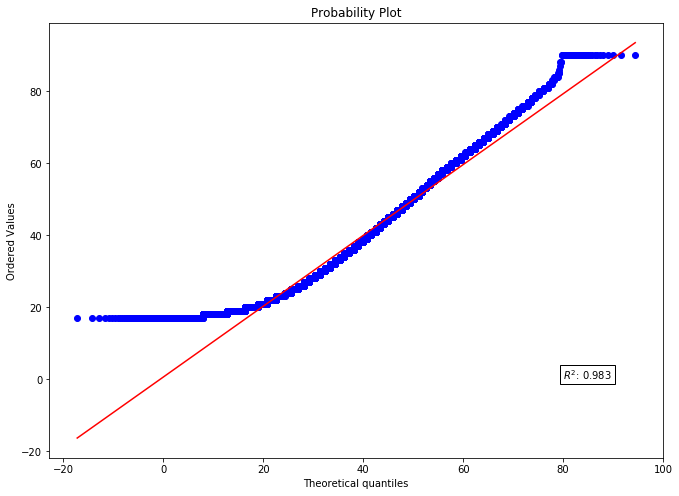

In [22]:
exploratory.qq_plot(table.age.astype(int))

#### Notes

The data fits a Normal distribution well, although this plot shows the lack of extentsion in the data's tails. A log transform would help to eliminate some or all of this skewness. However, this data is so close to being Normally distributed that I am going to leave this alone for now. 

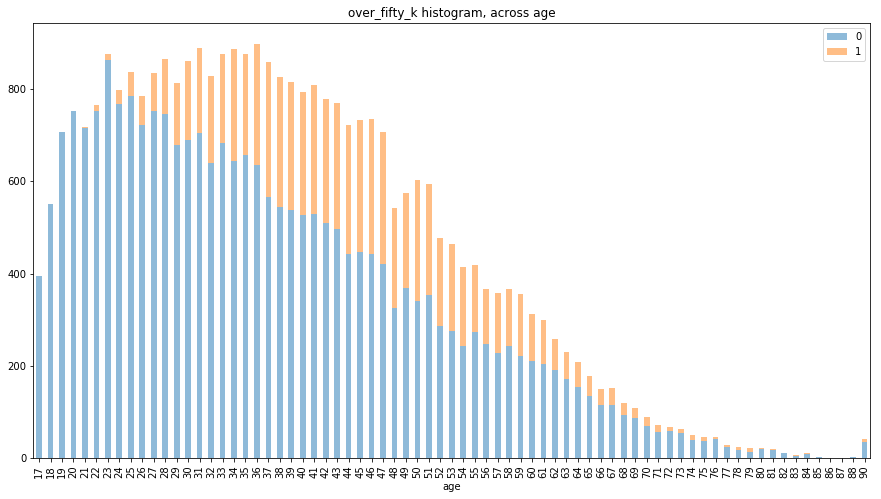

In [23]:
exploratory.feature_hist_by_class(table, 'over_fifty_k', 'age', figsize=(15, 8))

#### Notes

We can see that the <50K per annum earners fall towards the younger end of the spectrum, whereas the bulk of the higher earners are middle-aged.

In [24]:
table['age'] = table.age.astype(int)

### Education

In [25]:
table.education.nunique()

16

In [26]:
ed = table[['education', 'education_num']
          ].drop_duplicates().set_index('education', 
                                        drop=True)

In [27]:
ed['education_num'] = ed['education_num'].astype(int)

In [28]:
ed.sort_values('education_num')

,education_num
education,
Preschool,1
1st-4th,2
5th-6th,3
7th-8th,4
9th,5
10th,6
11th,7
12th,8
HS-grad,9


#### Notes

There is a one-to-one mapping of education to education_num. 

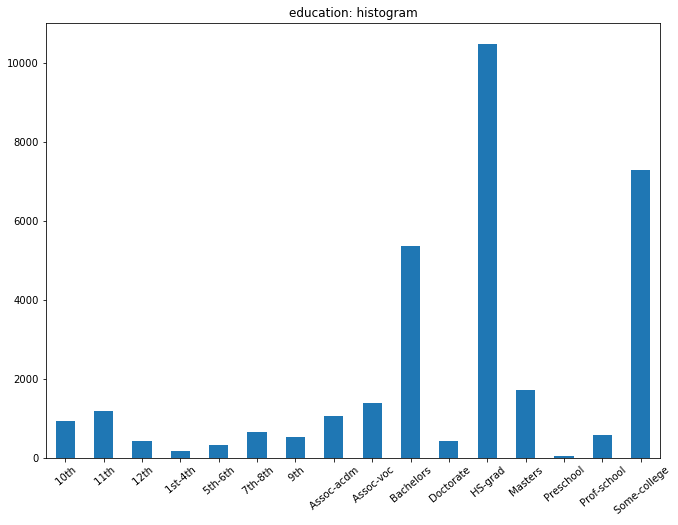

In [29]:
ax = table['education'].value_counts().sort_index(
                        ).plot.bar(figsize=(11, 8), rot=40)
ax.title.set_text('education: histogram')

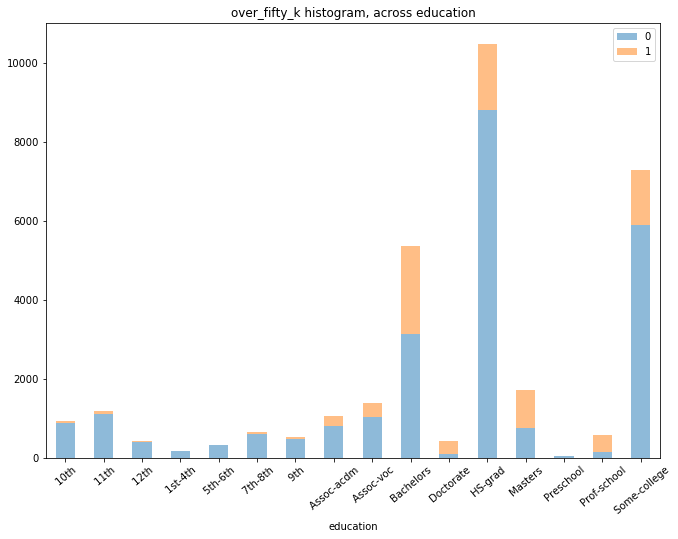

In [30]:
exploratory.feature_hist_by_class(table, 'over_fifty_k', 
                                  'education', rot=40)

In [31]:
table['education_num'] = table.education_num.astype(int)

#### Notes

High income is much more prevalent amongst the more-educated. 

### Education vs. age, by income class

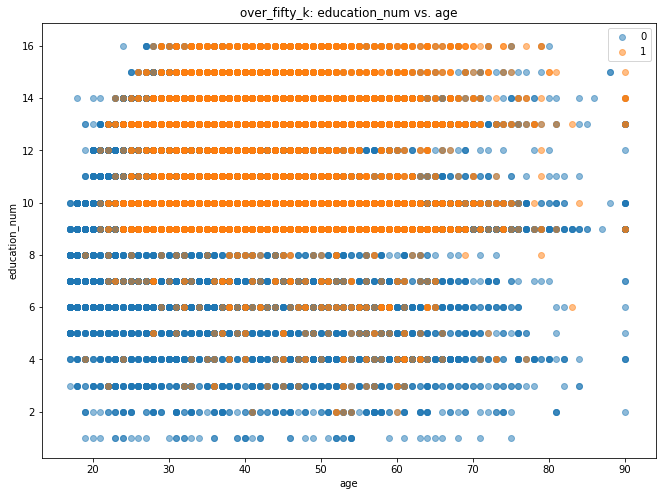

In [32]:
exploratory.scatter_by_class(table, 'over_fifty_k', 'age', 'education_num')

#### Notes

The more brownish regions in the above plot indicate an overlap between the classes. The bright orange here could indicate some pockets of predominantly over 50K earners. Let us continue examining other variables to see if a decision boundary becomes more clear. 

### Work class

In [33]:
table.workclass.nunique()

9

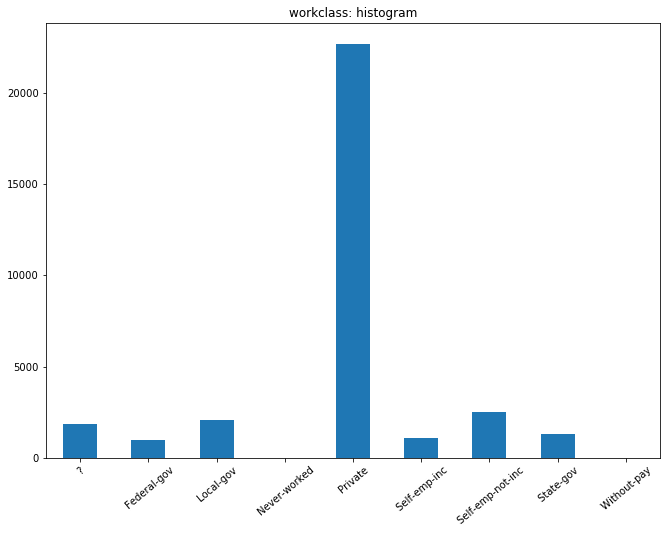

In [34]:
ax = table['workclass'].value_counts().sort_index(
                        ).plot.bar(figsize=(11, 8), rot=40)
ax.title.set_text('workclass: histogram')

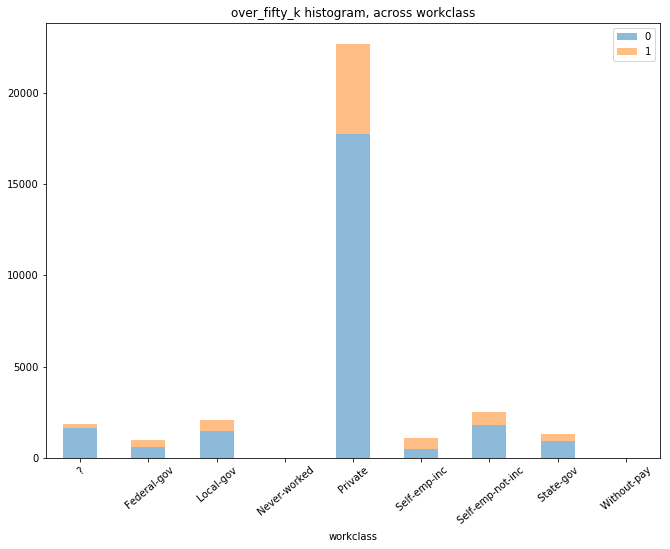

In [35]:
exploratory.feature_hist_by_class(table, 'over_fifty_k', 
                                  'workclass', rot=40)

#### Notes

Private sector employment seems to be housing the bulk of the high earners, though most of the people employed by the private sector in fact do not fall into the over \$50K bucket.

### Final weight

#### Notes

The UCI documentation describes this column as reflecting a by-state population demographic weight. Let's take a look at how this data is distributed. 

In [37]:
table.fnlwgt.nunique()

21648

In [38]:
table.fnlwgt = table.fnlwgt.astype(int)

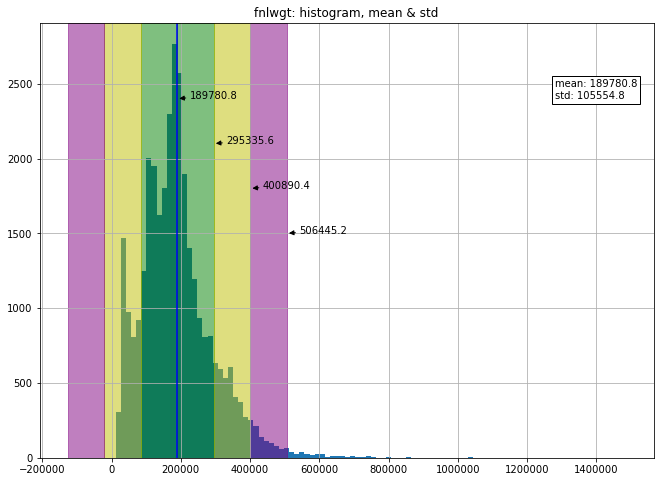

In [39]:
exploratory.center_scale_plot(table.fnlwgt, np.mean, np.std, bins=100)

#### Notes

The final weight data exhibits classic Lognormal positive skewness.

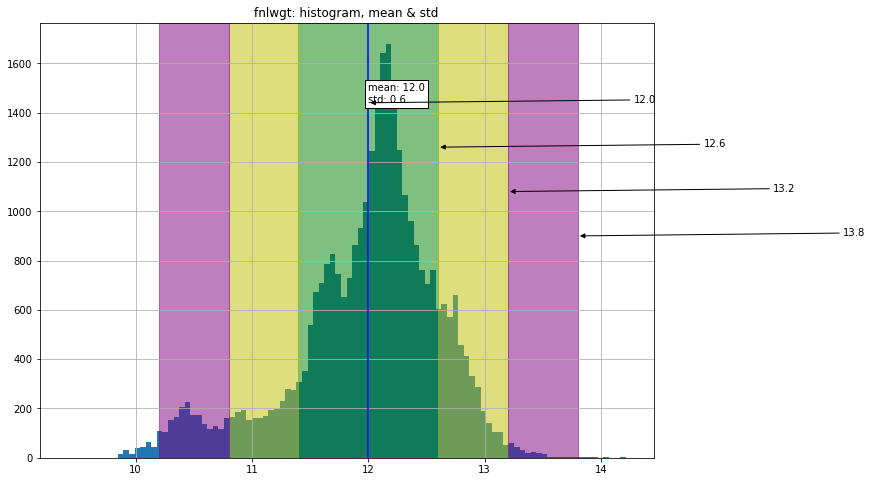

In [40]:
exploratory.center_scale_plot(np.log(table.fnlwgt), np.mean, np.std, bins=100)

#### Notes

Taking the log transform has yielded a more symmetrical dataset that sits almost entirely within 3 standard deviation bands.

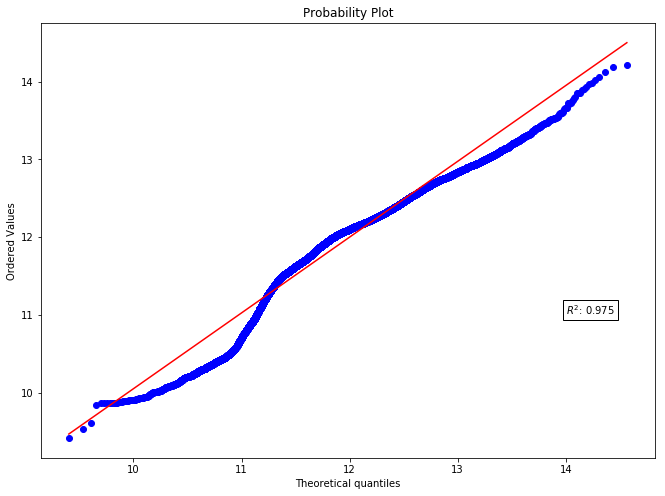

In [41]:
exploratory.qq_plot(np.log(table.fnlwgt))

#### Notes

Plotting the ordered final weight data against the quantiles of a Normal distribution with the same location and center, we achieve a high goodness-of-fit measure. The unusual lump in the data's left tail stands out on this QQ plot as it did on the above histogram. 

In [42]:
table['fnlwgt_log'] = np.log(table.fnlwgt)

### Final weight vs. age, by income class

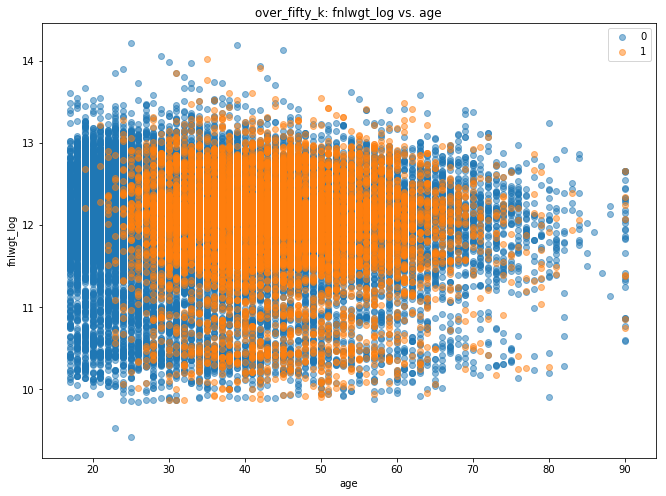

In [44]:
exploratory.scatter_by_class(table, 'over_fifty_k', 'age', 'fnlwgt_log')

#### Notes

There is definitely some overlap between age and fnlwgt.

### Final weight vs. education, by income class

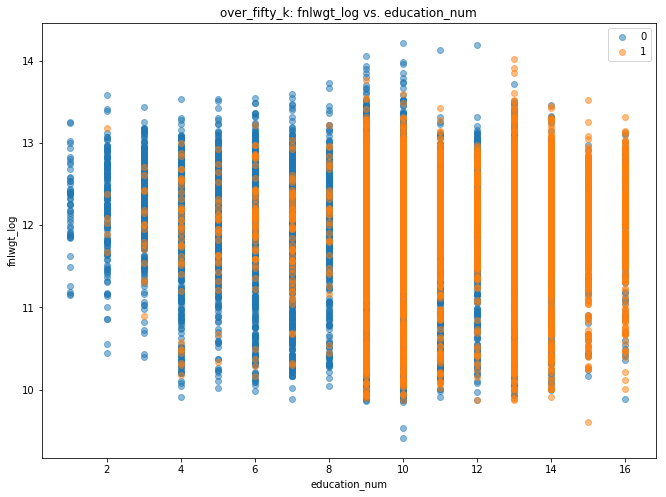

In [45]:
exploratory.scatter_by_class(table, 'over_fifty_k', 'education_num', 'fnlwgt_log')

#### Notes

It appears that the combination of fnlwgt & education, as with age & education, may provide some decent class differentiation, although there is still a good bit of overlap.

# 2. Modeling

#### Notes

There are several ways to proceed. Deeper EDA, a more robust feature analysis + feature engineering; unsupervised learning, which kind of falls into both of those categories, could also be performed. In this case, I am going to keep it simple: one-hot encode the categorical variables, leave the rest in their original states, and see what kind of results can be achieved using a Random Forest Classifier. 

A Decision Tree works by repeatedly splitting a dataset, 20- questions-style, in an effort to find feature values by which the dataset can be seperated into its proper classes. A Random Forest works by creating many different Decision Trees and then either averaging or taking the mode of the results, depending on whether you're performing regression (continuous responses) or classification (categorical responses).

There are a few reasons for which I am going to try a RFC here. For starters, based on the bit of EDA performed above, the decision boundary appears to be pretty complex - a linear model probably wouldn't do such a great job of sorting things out. And for the complexity they provide, RFCs train and predict with pretty good speed. 

Additionally, RFCs do not require a whole lot of data prep - *sklearn's* implementation really requires only that you one-hot encode your categorical features. Also convenient is the fact that training an RFC does not involve a whole lot of hyper parametrer tuning, which for a quick analysis can be somewhat of a bottle neck. Lastly, and importantly, RFCs can do a decent job of working with imbalanced classes (which we do have here) as they can be forced to build their internal Decision Trees using balanced subsamples of the data.

### Function to get modeling data

In [46]:
def get_model_data(table, features, dont_dummy):
    cols = ['over_fifty_k'] + features
    for_modeling = table[cols]
    to_dummy = list(filter(lambda _: _ not in dont_dummy,
                           cols))
    return pd.get_dummies(for_modeling, columns=to_dummy)

### Prep

In [47]:
table.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'over_fifty_k', 'fnlwgt_log'],
      dtype='object')

In [48]:
table.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
education_num       int64
marital_status     object
occupation         object
relationship       object
race               object
sex                object
capital_gain       object
capital_loss       object
hours_per_week     object
native_country     object
over_fifty_k        int64
fnlwgt_log        float64
dtype: object

In [49]:
table[['capital_gain', 
       'capital_loss',
       'hours_per_week']] = table[['capital_gain', 
                                  'capital_loss',
                                  'hours_per_week']
                               ].astype(int)

In [50]:
int_cols = list(table.dtypes[table.dtypes=='int64'].index.values)

In [51]:
int_cols

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'over_fifty_k']

In [52]:
X = ['age', 'workclass', 'fnlwgt', 'education_num',
     'marital_status', 'occupation', 'relationship', 
     'race', 'sex', 'capital_gain', 'capital_loss', 
     'hours_per_week', 'native_country']

### Get data

In [53]:
for_modeling = get_model_data(table, X, int_cols)

In [54]:
len(for_modeling.columns)

93

In [55]:
X_model = [col for col in for_modeling.columns if col != 'over_fifty_k']

### Cross validate

#### Notes

Cross validation involves slicing the data into *k* pieces (in this case 5) and, for each of the *k* folds, holding that fold out as a test set (the model will not have been trained on that data) and training on the rest. 

The results for the tests on each of the folds are then averaged. This methodology solves 2 common problems: 

- you can't depend on performance figures that stem from predicting data the model was trained on

- which data you test on and how much you use for training can bias results and leave you without much to test on

In [56]:
results = evaluation.cv_score(model=RandomForestClassifier(n_estimators=100,
                                                 class_weight='balanced_subsample'),
                                X=for_modeling[X_model],
                                y=for_modeling.over_fifty_k,
                                score_funcs=[accuracy_score,
                                             precision_score,
                                             recall_score])

In [57]:
results[['mean', 'std']]

mean       std
accuracy_score  train  0.999946  0.000044
                test   0.855641  0.002438
precision_score train  0.999904  0.000087
                test   0.742932  0.007451
recall_score    train  0.999872  0.000133
                test   0.613090  0.015323

#### Analysis

We've trained and tested here a Random Forest classifier with 2 hyper parameters passed:

- n_estimators determines the number of Decision Trees built

- class_weight with value 'balanced_subsample' tells the algorithm to build its trees using class-balanced subsamples

Our test accuracy of ~85.6% is on par with the results posted by this dataset's curator. But there are a couple of issues with these results:

- there is a large disparity between train and test results for all 3 of the scores we've calculated

- accuracy, especially when dealing with imbalanced classes, can be a very misleading metric

I've included accuracy as sort of a quick-n-dirty guide, but the precision and recall scores here are more important as they are based off of the results for the positive, over \$50K annually, class, which is underrepresented in the dataset. 

Precision tells us how reckless the model was in making its positive predictions. The higher the score, the more careful the model. Recall tells us how much money was left on the table, so to speak. The higher the recall, the greater the percent of all positive class instances identified.

We can attempt to implement some prepruning, which means limiting the growth of the RFC's internal Decision Trees, in an effort to curb the overfitting. 

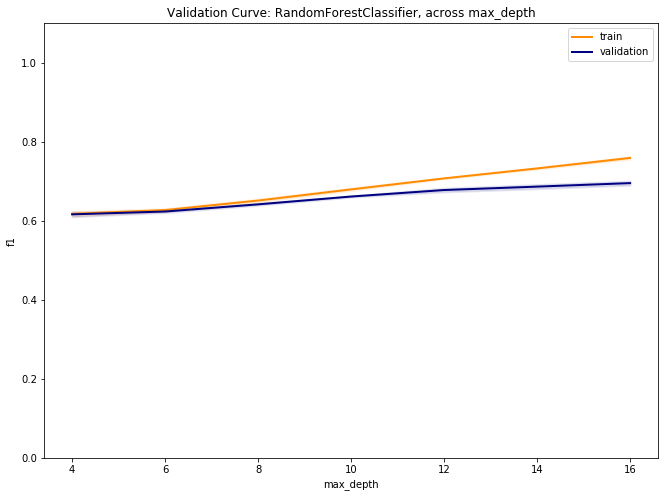

In [58]:
curves.validation_curve(RandomForestClassifier,
                        X=for_modeling[X_model],
                        y=for_modeling.over_fifty_k,
                        param_name='max_depth',
                        param_range=np.linspace(4, 16, 7),
                        other_params={'class_weight':'balanced_subsample',
                                      'n_estimators':100},
                        score='f1')

#### Analysis

The above validation curve plots cross validation performance for the model across different levels of prepruning. The lower 'map_depth' is, the stronger the prepruning. As max_depth increases, the train and test scores diverge, which is a good sign of overfitting.

The performance metric being used here is called f1 score. f1 is the harmonic mean of precision and recall, which means that if you have to choose one number, this is a good way to go as it accounts for both care and thoroughness, so to speak. Additionally, this measure is calculated on the positive class, which means that we will know if our model is simply dumping all predictions into whichever class is more present in the dataset. 

In this case, while the values of f1 are not quite as high as one might like them to be, I do like that they are relatively consistent - even with strong prepruning, the model is still doing OK.

I am going to continue evaluation with a max_depth of 14, as the train and test divergence is still pretty tame, and the performance is noticeably better than it is towards the left end of the plot.

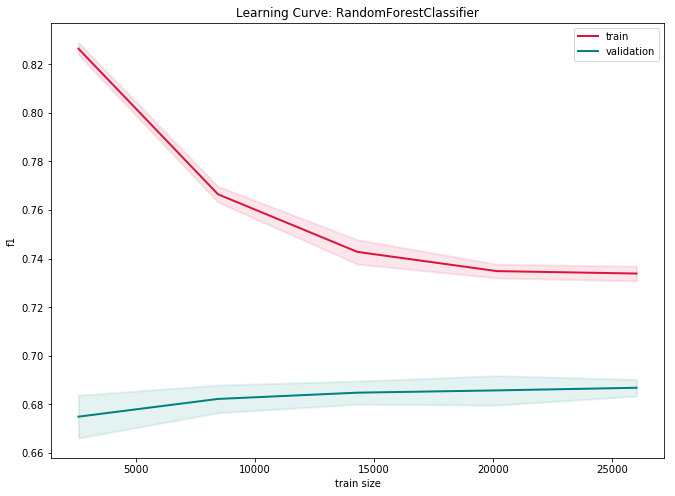

In [59]:
curves.learning_curve(RandomForestClassifier,
                      model_params={'class_weight':'balanced_subsample',
                                    'n_estimators':100,
                                    'max_depth': 14},
                      X=for_modeling[X_model],
                      y=for_modeling.over_fifty_k,
                      score='f1')

#### Analysis

In the above learning curve, the model is trained and tested over varying amounts of training data.

There is some overfitting, but the model's results are consistent even at small training sizes. We see a slight upward sloping of the validation performance as training size is increased. A good slope generally indicates that the model has fit the data well - the more information it recieves, the better it does.

In this case, we may be underfitting the data a bit. In other words, we may be both overfitting and underfitting: the model has learned more about the training data set than it has about the data in general, and the model also does not seem to be making the most out of its access to more information.

But at the same time, the model is providing very consistent results. The fact that the model is putting up decent performance when trained on roughly 10% of the dataset is a good indicator of stability. And to develop a stronger fit to the underlying data, we may have to jump through some serious hoops with a different modeling framework - something like a Neural Network could require us to create a balanced resampling of the data ourselves, and something like an SVM would surely require more tuning and would also prove fairly painful to train (from a time perspective). 

With this model, we know what we are getting, and we did not have to do anything to the data that might make our results less reliable or difficult to replicate in any way, which is valuable. At this point, for the purposes of a quick analysis, I like this model and will continue diving further into its performance.

In [60]:
evaluation.cv_conf_mat(model=RandomForestClassifier(n_estimators=100,
                                                    class_weight='balanced_subsample',
                                                    max_depth=14),
                       X=for_modeling[X_model],
                       y=for_modeling.over_fifty_k,
                       splits=3)

neg_pred  pos_pred
1 neg_true      6570      1663
  pos_true       400      2213
2 neg_true      6585      1648
  pos_true       397      2216
3 neg_true      6594      1638
  pos_true       354      2259

#### Analysis

To really come to an opinion on how a model's working, it is good to take a look at what it's putting where, which is what the above confusion matrices show us (1 for each of 3 trials). It doesn't seem like anything crazy is happening - these numbers reflect the aggregate scores we looked at above.

### Test situation
    
Taking the confusion matrix further one can put a value on each correct or incorrect prediction. This makes the notion of a score less abstract and more aligned with a business objective.

Example: you are selling insurance to people, and these people will only buy your insurance if they are making more than \$50K annually. It will cost you \$100 to advertise this insurance to them, and you will make \$1000 if a potential client converts. 

#### Set up cost funcs

In [61]:
def cost(true, pred):
    # true negative, no cost
    if true == 0 and pred == 0:
        return 0
    # false positive, lose $100 to advertising
    elif true == 0 and pred == 1:
        return 100
    # false negative, missed out on a grand
    elif true == 1 and pred == 0:
        return 1000
    # true positive, spend $100 to get $1000
    elif true == 1 and pred == 1:
        return -900

In [62]:
def model_cost(y_true, y_pred):
    func = np.vectorize(cost)
    return func(y_true, y_pred).sum()

#### Cross validate

In [63]:
results = evaluation.cv_score(model=RandomForestClassifier(n_estimators=100,
                                                 class_weight='balanced_subsample',
                                                 max_depth=14),
                                X=for_modeling[X_model],
                                y=for_modeling.over_fifty_k,
                                score_funcs=[model_cost])

In [64]:
results[['mean', 'std']]

mean           std
model_cost train -4289640.0  26742.812118
           test   -883120.0  23925.342213

#### Analysis

We've set up an aggressive cost function here where poor *recall* is heavily penalized, which makes sense given the business model. Fortunately, our model is coming in on the right side of zero (this is a measurement of cost so negative is good). 

It's worth noting that there's a large disparity between train and test error. This could be an indication of overfitting. That said, the standard deviation, proportionately speaking, is quite small. Both of these qualities, overfitting but also consistency - were revealed to us in our learning curve analysis above. 

One thing we can do to optimize our cost here is tweak our decision boundary. *sklearn's* models default to a boundary of .5 for binary classification. Since we are much more interested in recall than precision (we want to nail as many positives as possible and are OK with some false positives) we can lower that decision bounday a bit. Or in other words, we're going to tell the model to be a little more aggressive in looking for positive classifications. 

### Adjust boundaries

#### New RF Classifier that predicts probabilities

To do this, we are going to have to put a wrapper around the *sklearn* Random Forest class. I built my cross-validation tools to (for now) mimic the functionality of the *sklearn* tools, which means they are looking for every model to have a predict method. We can however change the functionality of said predict method so that it predicts class probabilities instead of labels. 

In [65]:
class RFProb(RandomForestClassifier):
    def predict(self, X):
        return self.predict_proba(X)

#### Modify cost mechanisms to convert probability to label

In [66]:
def prob_to_class(func):
    def convert(y_true, y_pred):
        pos_class = y_pred[:, 1]
        conv = np.vectorize(lambda _: 1 if _ > .4 else 0)
        return func(y_true, conv(pos_class))
    return convert

In [67]:
@prob_to_class
def model_cost(y_true, y_pred):
    func = np.vectorize(cost)
    return func(y_true, y_pred).sum()

#### Cross validate

In [68]:
results = evaluation.cv_score(model=RFProb(n_estimators=100,
                                 class_weight='balanced_subsample',
                                 max_depth=14),
                                X=for_modeling[X_model],
                                y=for_modeling.over_fifty_k,
                                score_funcs=[model_cost])

In [69]:
results[['mean', 'std']]

mean           std
convert train -4664260.0  11917.550084
        test  -1012160.0  16510.390668

In [91]:
-1012160.0 / -883120.0

1.146118307817737

#### Notes

We have seen an improvement here, subtracting roughly 15% from our test cost. We can push this boundary even further if we'd like.

#### Rework functions to allow for threshold testing

In [71]:
def cost(true, pred):
    if true == 0 and pred == 0:
        return 0
    elif true == 0 and pred == 1:
        return 100
    elif true == 1 and pred == 0:
        return 1000
    elif true == 1 and pred == 1:
        return -900

In [72]:
def model_cost(y_true, y_pred):
    func = np.vectorize(cost)
    return func(y_true, y_pred).sum()

In [73]:
def prob_to_class(t, func):
    def convert(t, y_true, y_pred):
        pos_class = y_pred[:, 1]
        conv = np.vectorize(lambda _: 1 if _ > t else 0)
        return func(y_true, conv(pos_class))
   
    def threshold(t):    
        partial_func = partial(convert, t)
        update_wrapper(partial_func, convert)
        return partial_func
    
    return threshold(t)

In [74]:
def boundary_cost(t):
    return prob_to_class(t, model_cost)

#### Function to cross validate over multiple boundaries

In [75]:
def test_boundaries():
    i, results = .55, {}
    while i > .25:
        results[i] = \
        evaluation.cv_score(model=RFProb(n_estimators=100,
                                         class_weight='balanced_subsample',
                                         max_depth=14),
                            X=for_modeling[X_model],
                            y=for_modeling.over_fifty_k,
                            score_funcs=[boundary_cost(i)])
        i -= .05
    return pd.concat(results)

#### Run cross validation

In [76]:
results = test_boundaries()

In [77]:
results[['mean', 'std']]

mean           std
0.25 convert train -4809640.0   9848.756267
             test  -1107040.0  15236.239694
0.30 convert train -4799940.0   2934.791304
             test  -1088600.0  15111.750395
0.35 convert train -4768320.0   9591.767303
             test  -1046180.0  18045.137849
0.40 convert train -4674920.0  16059.794519
             test  -1012660.0  14693.638079
0.45 convert train -4547800.0  25805.716421
             test   -952420.0  14799.560804
0.50 convert train -4298760.0  10650.023474
             test   -879300.0  23954.435915
0.55 convert train -3938260.0  27970.305683
             test   -788800.0  31424.592281

#### Analysis

We can see test cost decrease as the decision threshold is lowered. I wonder if the disparity between train and test costs may have something to do with the larger size of the training set? (this is an absolute, not %, cost)

In [92]:
-1107040.0 / -4809640.0

0.2301710730948678

These results were calculated through 5-fold cross validation, which means testing was performed on 20% (stratified by class) of the dataset - that may be a part of where this disparity is coming from, which would mean that overfitting is perhaps not as much of an issue here as was originally imagined. For the purposes of this analysis (since the business model is a bit ludicrous anyway) I will continue onwards with a decision threshold of 25%.

### Train and test final model

#### Instantiate model

In [79]:
model = RFProb(n_estimators=100,
               class_weight='balanced_subsample',
               max_depth=14)

#### Data

In [80]:
X = X=for_modeling[X_model]

In [81]:
y = y=for_modeling.over_fifty_k

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35)

#### Train

In [83]:
model = model.fit(X_train, y_train)

#### Scores

In [84]:
y_pred = model.predict(X_test)

In [85]:
def convert(t, y_pred):
    pos_class = y_pred[:, 1]
    conv = np.vectorize(lambda _: 1 if _ > t else 0)
    return conv(pos_class)

In [86]:
y_pred_class = convert(.25, y_pred)

#### Analysis

In [93]:
conf_mat = confusion_matrix(y_test, y_pred_class)

In [94]:
conf_mat

array([[5417, 3219],
       [ 113, 2639]])

In [88]:
boundary_cost(.25)(y_test, y_pred)

-1940200

In [95]:
'recall: {}'.format(conf_mat[1][1] / conf_mat[1, :].sum())

'recall: 0.9589389534883721'

In [96]:
'precision: {}'.format(conf_mat[1][1] / conf_mat[:, 1].sum())

'precision: 0.4504950495049505'

Training on 65% (stratified & randomly selected) of the dataset, we've achieved a recall score of roughly 96% through our decision boundary adjustments.